This notebook contains analysis of the pattern glare offset period using MNE.

To ensure the data is correct, all preprocessing has been done using FieldTrip in matlab.


In [1]:
# Importing custom package to load the FT data into MNE correctly#
import numpy as np

import utils.data as ft_load
import mne
import warnings
warnings.filterwarnings('ignore')

Starting with loading the participant level data, The main timeseries is the Pattern glare index (PGI), all 3 conditions series are loaded into the array as well.

In [3]:
%%capture
participant_data_name = "time_domain_mean_intercept_onsets_2_3_4_5_6_7_8_trial_level_onsets.mat"
data = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(2.8, 3.0))[0]

Visualising the PGIs, Both at all electrodes as well as most significant (previously found) B10 & A14

In [4]:
import matplotlib.pyplot as plt

Identifying common channels ...


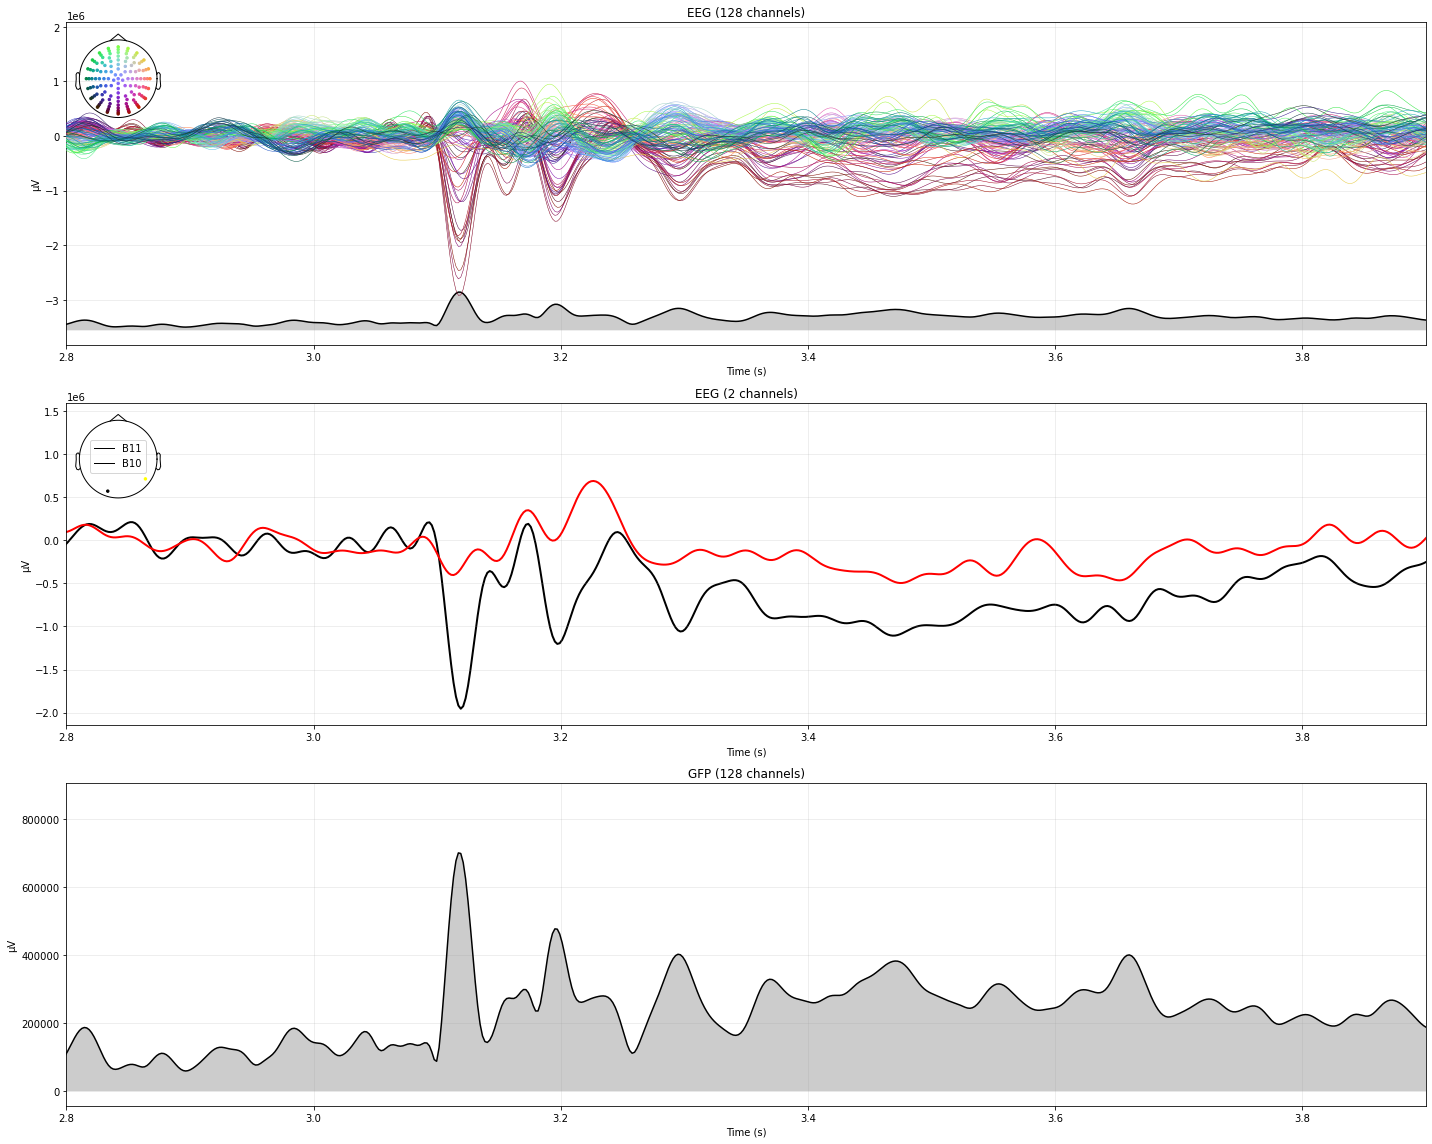

In [9]:
# setting up plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 16))
fig.patch.set_facecolor('white')

# grand average of erp from participants
ga = mne.grand_average(data);
# plotting all channels and GFP with locations
ga.plot(spatial_colors= True, gfp=True, xlim=[2.8, 3.9], axes=axes[0], show=False)
# plotting 2 significant ERPs no CI
ga.plot(spatial_colors= True, picks=["A14"], gfp=False, xlim=[2.8, 3.9],axes=axes[1], show=False);
# Plotting GFP on seperate graph
ga.plot(spatial_colors= True, gfp="only", xlim=[2.8, 3.9],axes=axes[2], show=False);

for plots in range(0,len(axes)):
    for text in list(axes[plots].texts):
        text.remove()    

axes[1].get_lines()[0].set_linewidth(2)
axes[1].get_lines()[1].set_linewidth(2)
axes[1].get_lines()[1].set_color('red')
axes[1].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[0].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[2].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[2].title.set_text('GFP (128 channels)')
fig.tight_layout()
plt.gca().legend(('B11','B10'))
plt.rc('grid', linestyle="-", color='black')
plt.savefig("images/ERP_Offset_PGI.png")
plt.show()

Visualising the ERPs and loading in epoched trial level data

In [5]:
%%capture
thin,med,thick = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(-0.2, 0))[1:4]

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


<Figure size 432x288 with 0 Axes>

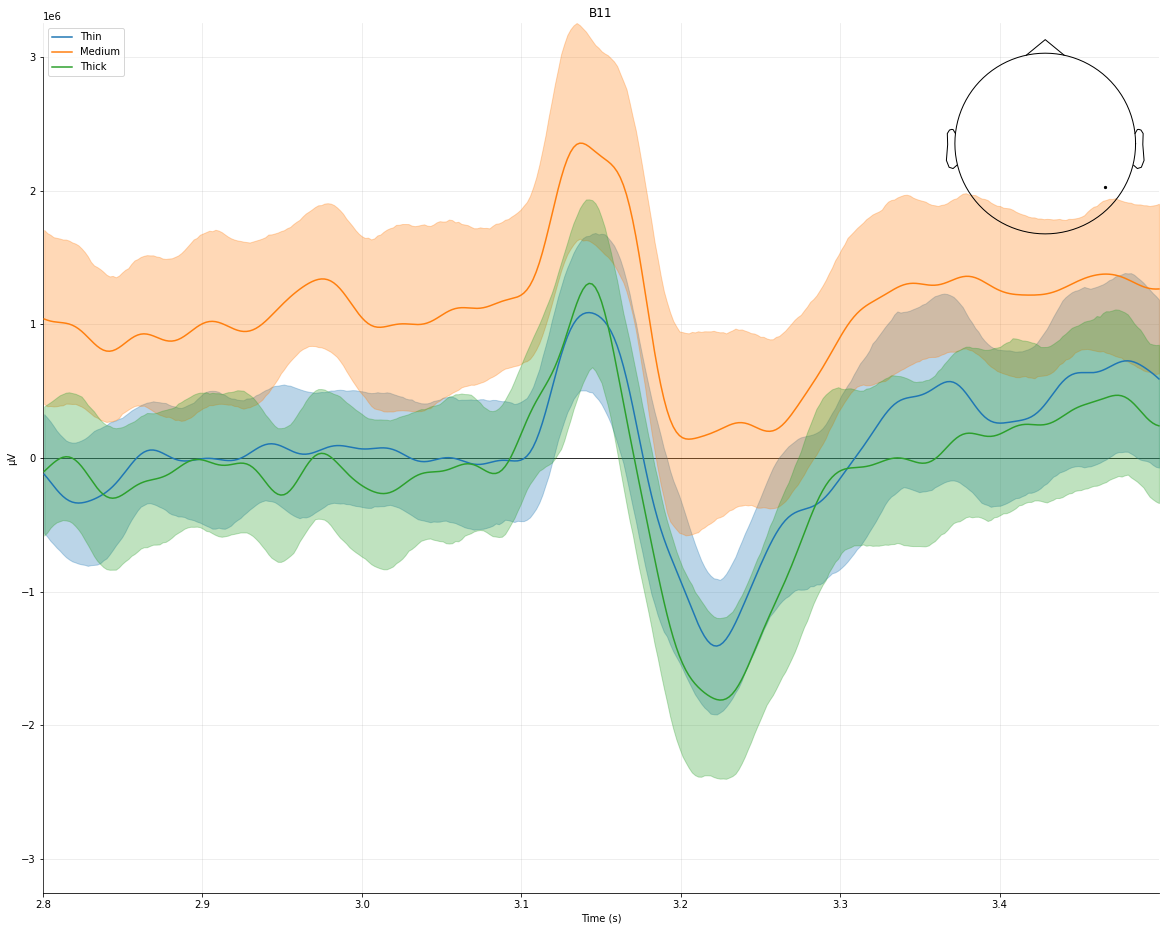

In [7]:
import utils.time_series as ts

lower = 2.8
upper = 3.5

plt.clf()
evokeds = dict(Thin=ts.shorten_data(thin,lower,upper),
                Medium=ts.shorten_data(med,lower,upper),
                Thick=ts.shorten_data(thick,lower,upper))


fig, axes = plt.subplots(figsize=(20, 16))
fig.patch.set_facecolor('white')
axes.grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes.set_aspect('auto')
mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=['B11'], ci=True, axes=axes,show=False,truncate_xaxis=False)
for text in list(axes.texts):
        text.remove()


plt.show()

Mean intercept statistics

In [7]:
from mne.stats import permutation_cluster_1samp_test

# gets the
stat_data = mne.grand_average(data).crop(2.8, 4)
adjacency, ch_names = mne.channels.find_ch_adjacency(stat_data.info, 'eeg')
#adjacency = mne.stats.combine_adjacency(ch_adj,len(stat_data.times))
stat = stat_data.get_data().transpose(1, 0)
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(stat, tail=0,
                                   adjacency=adjacency,
                                   n_permutations=5000,
                                   out_type='mask', verbose=True)

print("Smallest P val is " + str(min(cluster_p_values)))

Identifying common channels ...
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 128
Using a threshold of 1.963841
stat_fun(H1): min=-32.599412 max=31.983904
Running initial clustering
Found 7 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Smallest P val is 0.0002


Moving onto statistics - Against 0 (mean intercept) we can use a similar function to fieldtrip, however with the regressors we will have to use a parametric approach

In [8]:
data = ft_load.get_participant_epoch(data)

Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped


In [9]:
from mne.stats import fdr_correction, bonferroni_correction
import pandas as pd
names = ["Intercept", "Stress"]
design = ft_load.get_design_matrix("visual_stress")
res = mne.stats.linear_regression(data, design, names=names)
reject_H0, fdr_pvals = fdr_correction(res["Stress"].p_val.data)
evoked = res["Stress"].beta

min_p = np.amin(fdr_pvals)
loc_min_p = np.where(fdr_pvals==min_p)
print("Smallest P val is " + str(min_p))

Fitting linear model to epochs, (78720 targets, 2 regressors)
Done
Smallest P val is 0.03471476937764016


In [10]:
%%capture
data = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(-0.2, 0))[0]
data = ft_load.shorten_data(data)
plotmap = mne.grand_average(data)
axes = plotmap.plot_joint(times=[3.119,3.2,3.7231],title="Significant Visual Stress Clusters", show=False)
axes.set_facecolor("white")
axes.set_size_inches(18.5, 10.5)
plt.savefig("images/ERP with joined topo.png")
plt.show()

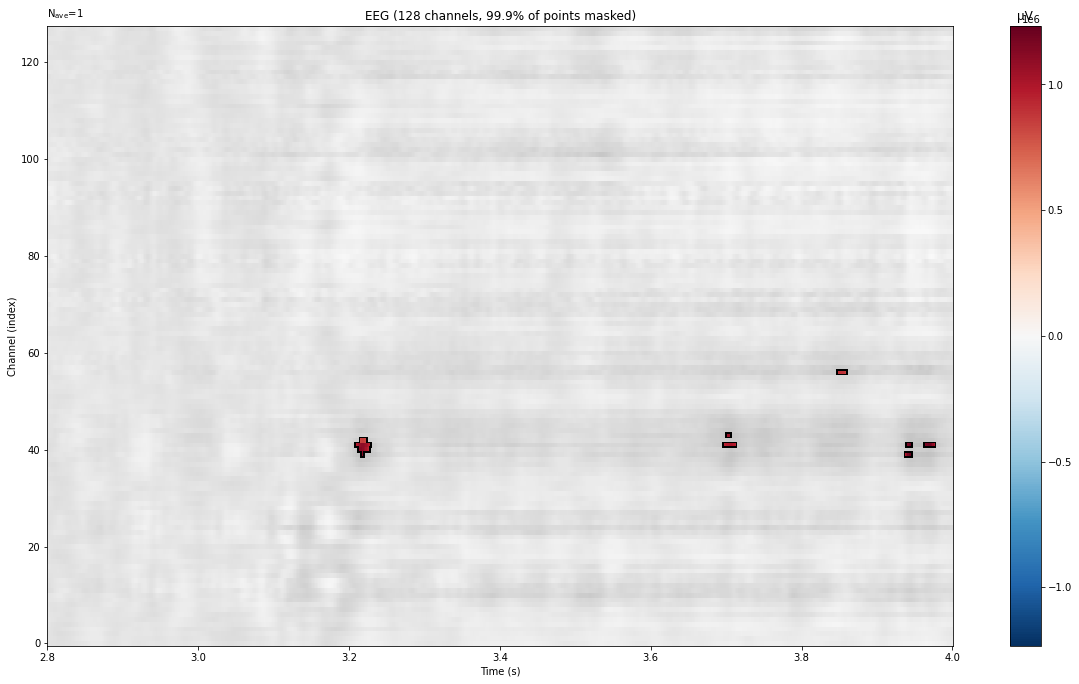

In [11]:
axes = evoked.plot_image(mask=reject_H0, time_unit='s',show=False)
axes.set_facecolor("white")
axes.set_size_inches(18.5, 10.5)
plt.savefig("images/significant electrodes.png")
plt.show()

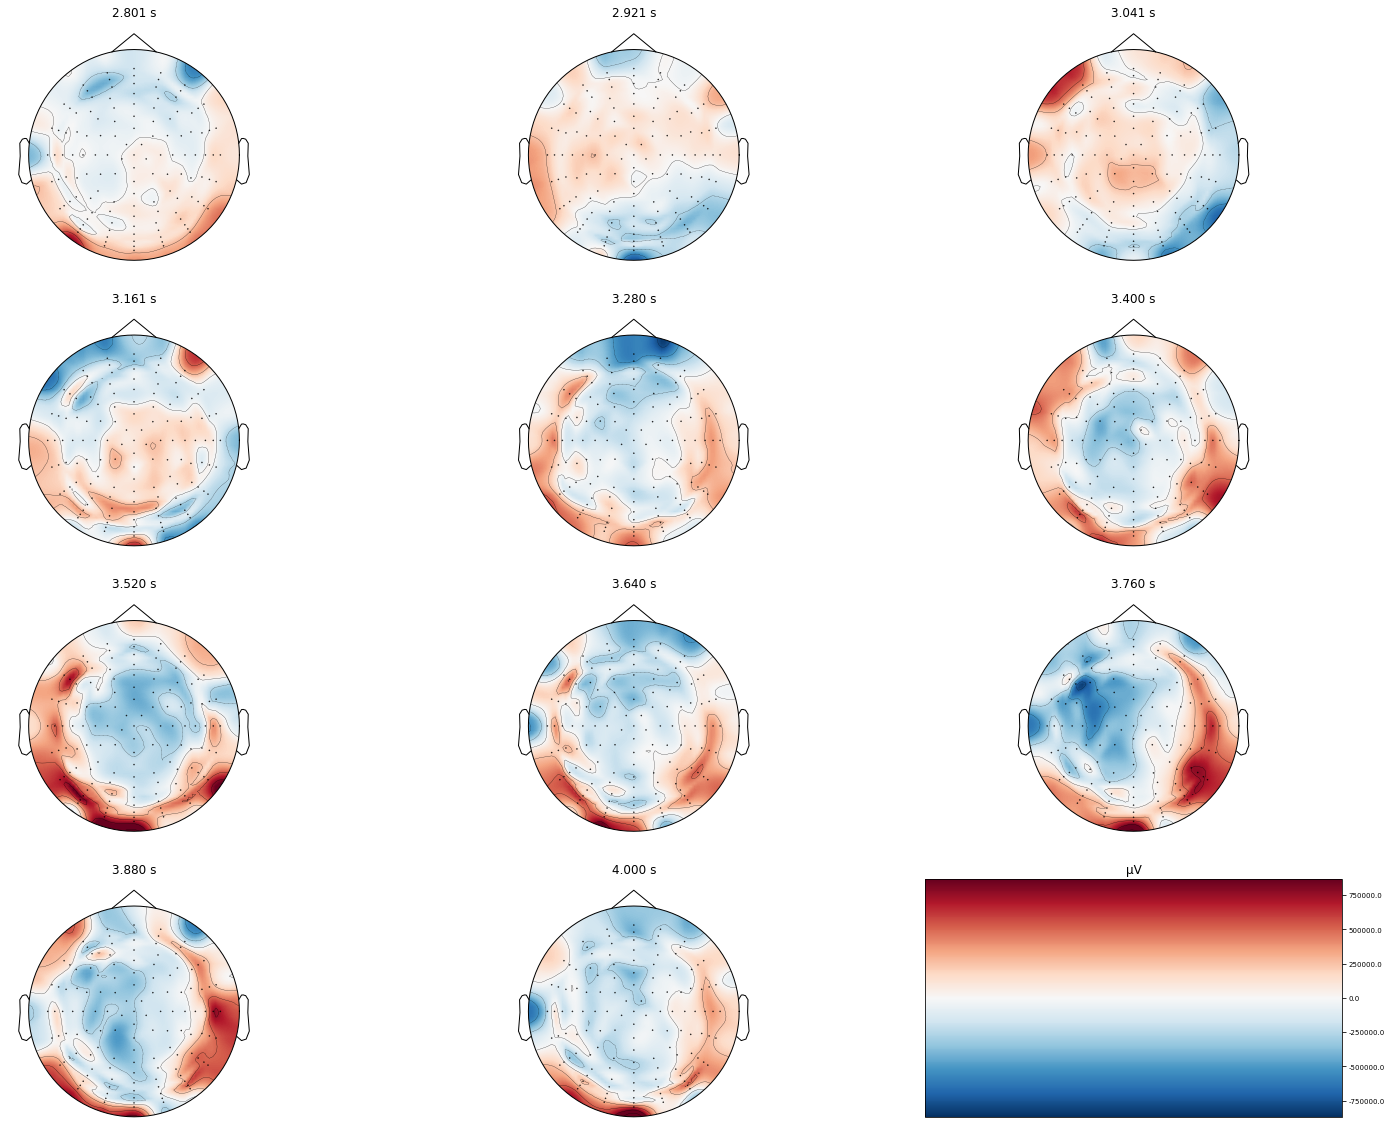

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 16))
axes = axes.ravel()
fig.patch.set_facecolor('white')
evoked.plot_topomap(show=False,colorbar=True,axes=axes)
plt.show()

Visual stress p Values on topographic map

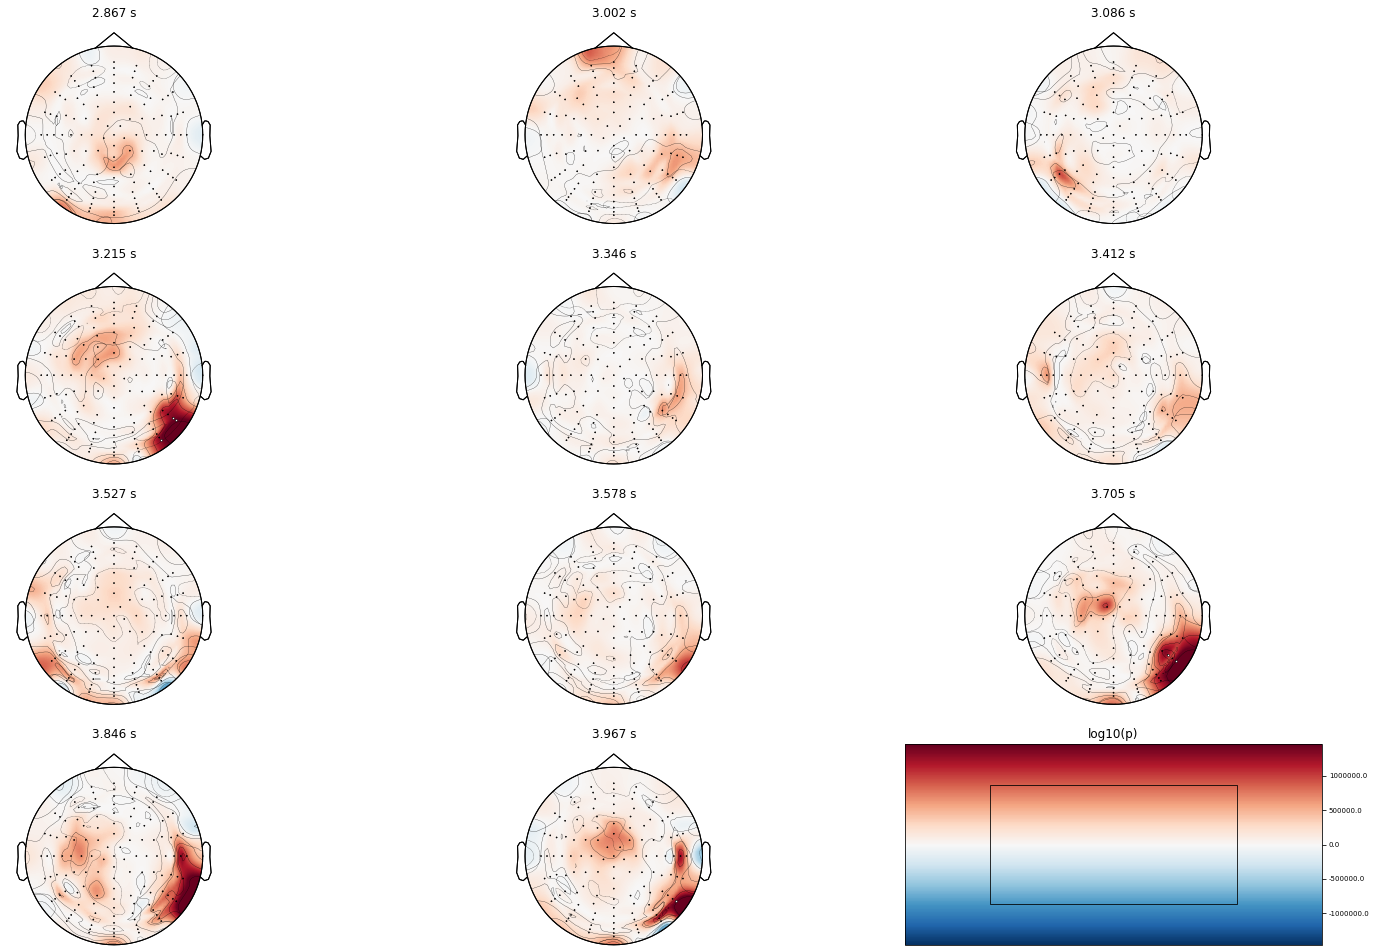

<Figure size 432x288 with 0 Axes>

In [13]:
import numpy as np
evoked = mne.EvokedArray(-np.log10(fdr_pvals)[:, np.newaxis].squeeze(),
                         data[0].info, tmin=2.8)

mask = fdr_pvals[:, np.newaxis] <= 0.05
mask = mask.squeeze()
evoked.plot_topomap(mask=reject_H0,show=False,colorbar=True,axes=axes,units='log10(p)', cbar_fmt='%0.1f',times='peaks')

Visual Stress Median Split at B10 and A14

In [14]:
%%capture
data = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(-0.2, 0))[0]


In [23]:
%%capture
data,thin,med,thick = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(2.8,3.0))
thin_low, thin_high = ft_load.get_median_split(design,thin)
med_low, med_high = ft_load.get_median_split(design,med)
thick_low, thick_high = ft_load.get_median_split(design,thick)
pgi_low, pgi_high = ft_load.get_median_split(design,data)

Need to get stat for visual stress to plot topomaps from matlab since MNE doesnt seem to have a funtion that is good enough

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


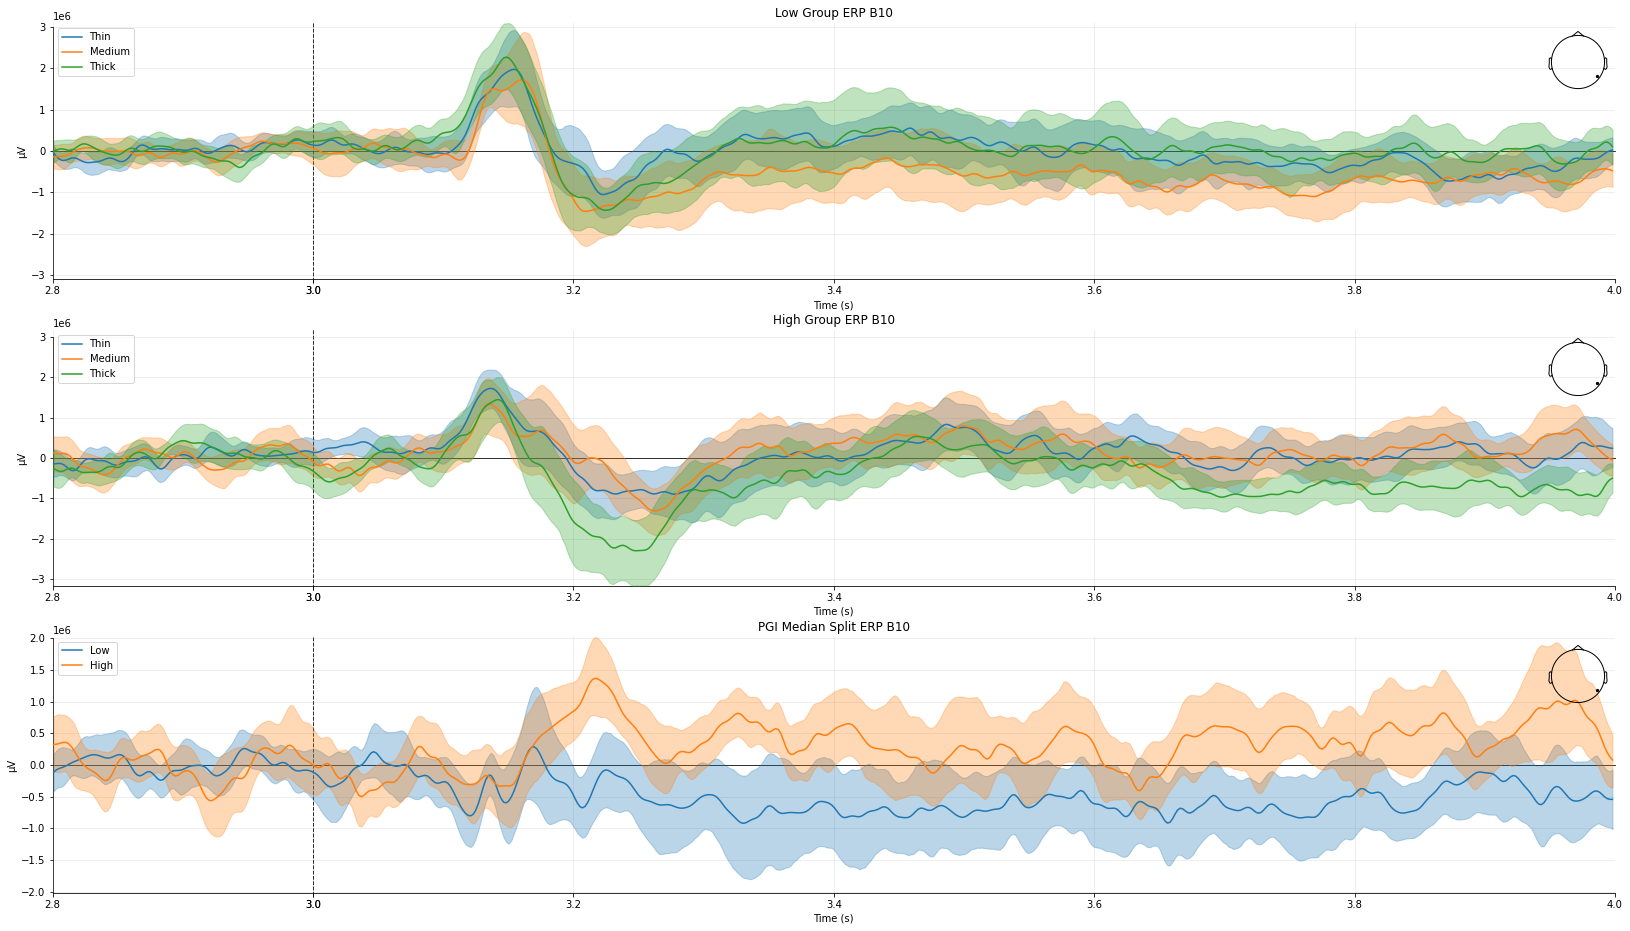

In [24]:
# setting up plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(28, 16))
fig.patch.set_facecolor('white')
lower = 2.8
upper = 4

low_evokeds = dict(Thin=ts.shorten_data(thin_low,lower,upper),
                Medium=ts.shorten_data(med_low,lower,upper),
                Thick=ts.shorten_data(thick_low,lower,upper))

high_evokeds = dict(Thin=ts.shorten_data(thin_high,lower,upper),
                Medium=ts.shorten_data(med_high,lower,upper),
                Thick=ts.shorten_data(thick_high,lower,upper))

pgi_evoked = dict(Low=ts.shorten_data(pgi_low,lower,upper),
                High=ts.shorten_data(pgi_high,lower,upper))

mne.viz.plot_compare_evokeds(low_evokeds,vlines=[3],title="Low Group ERP B10", combine='mean', picks=['B10'], ci=True, axes=axes[0],show=False,truncate_xaxis=False)
for text in list(axes[0].texts):
        text.remove()
mne.viz.plot_compare_evokeds(high_evokeds,vlines=[3],title="High Group ERP B10", combine='mean', picks=['B10'], ci=True, axes=axes[1],show=False,truncate_xaxis=False)
for text in list(axes[1].texts):
        text.remove()
mne.viz.plot_compare_evokeds(pgi_evoked,vlines=[3],title="PGI Median Split ERP B10", combine='mean', picks=['B10'], ci=True, axes=axes[2],show=False,truncate_xaxis=False)
for text in list(axes[2].texts):
        text.remove()

axes[0].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[1].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[2].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
plt.savefig("images/ERP_CI_B10.png")
plt.show()

Now without CI

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


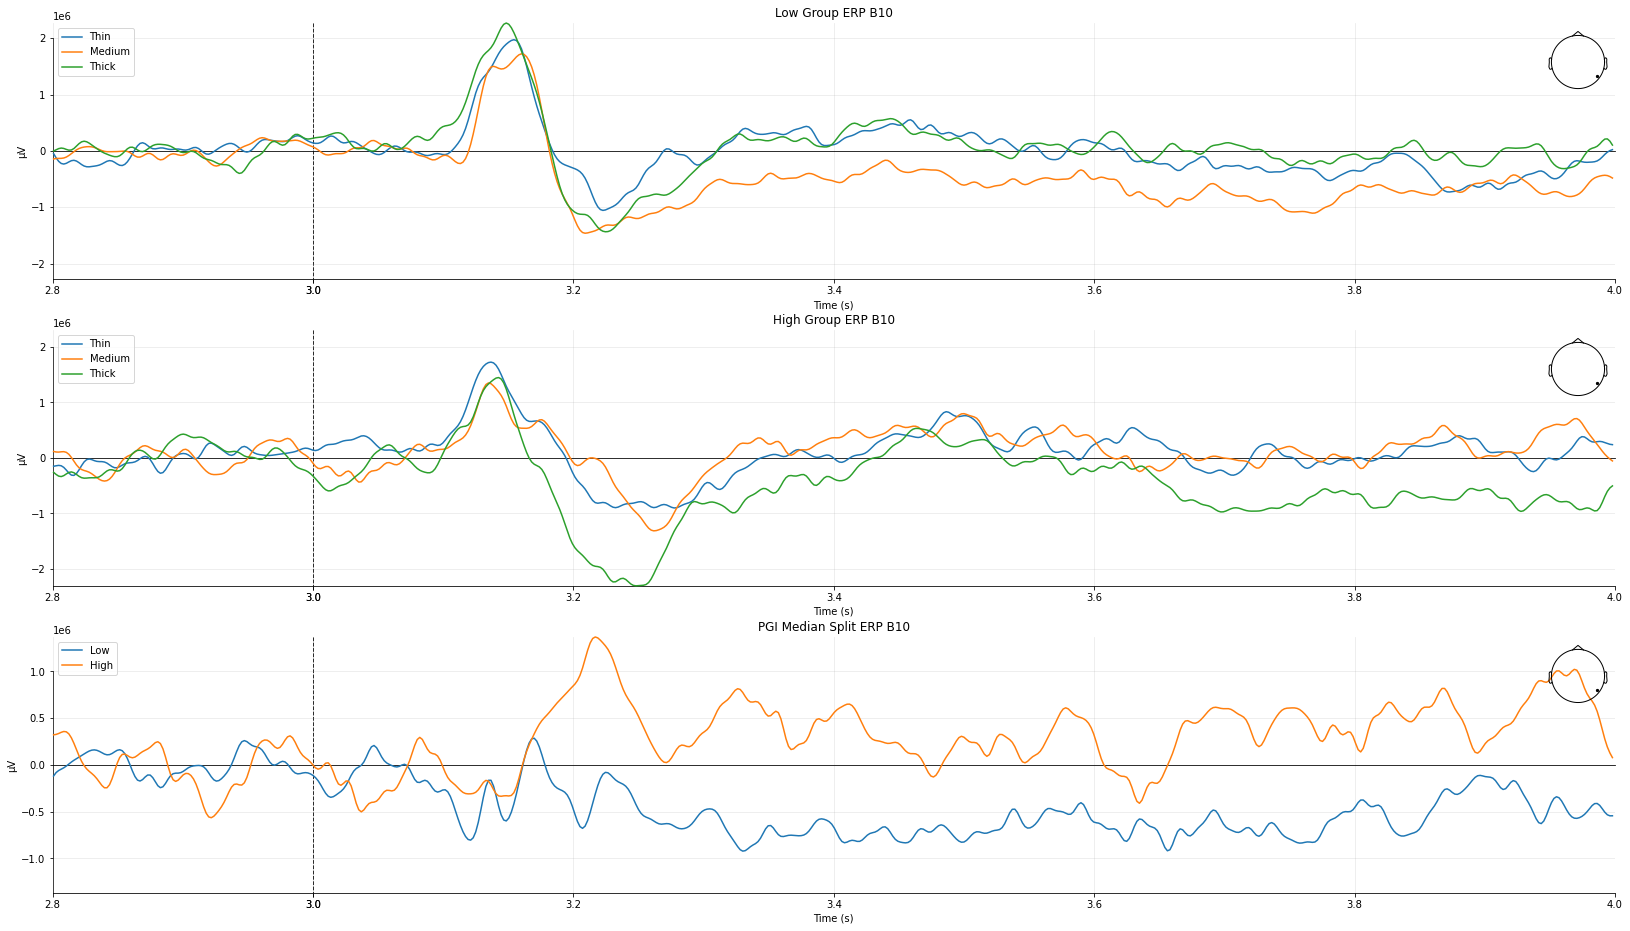

In [25]:
# setting up plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(28, 16))
fig.patch.set_facecolor('white')
lower = 2.8
upper = 4

low_evokeds = dict(Thin=ts.shorten_data(thin_low,lower,upper),
                Medium=ts.shorten_data(med_low,lower,upper),
                Thick=ts.shorten_data(thick_low,lower,upper))

high_evokeds = dict(Thin=ts.shorten_data(thin_high,lower,upper),
                Medium=ts.shorten_data(med_high,lower,upper),
                Thick=ts.shorten_data(thick_high,lower,upper))

pgi_evoked = dict(Low=ts.shorten_data(pgi_low,lower,upper),
                High=ts.shorten_data(pgi_high,lower,upper))

mne.viz.plot_compare_evokeds(low_evokeds,vlines=[3],title="Low Group ERP B10", combine='mean', picks=['B10'], ci=False, axes=axes[0],show=False,truncate_xaxis=False)
for text in list(axes[0].texts):
        text.remove()
mne.viz.plot_compare_evokeds(high_evokeds,vlines=[3],title="High Group ERP B10", combine='mean', picks=['B10'], ci=False, axes=axes[1],show=False,truncate_xaxis=False)
for text in list(axes[1].texts):
        text.remove()
mne.viz.plot_compare_evokeds(pgi_evoked,vlines=[3],title="PGI Median Split ERP B10", combine='mean', picks=['B10'], ci=False, axes=axes[2],show=False,truncate_xaxis=False)
for text in list(axes[2].texts):
        text.remove()

axes[0].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[1].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[2].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
plt.savefig("images/ERP_no_CI_B10.png")
plt.show()


plotting vs scores vs electrode value (PGI) at B10

In [18]:
%%capture
data = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(-0.2, 0))[0]
lower = 2.8
upper = 4

data = ts.shorten_data(data,lower,upper)
design = ft_load.get_design_matrix("visual_stress")

channel = 40
time = 463

lendat = len(data)


In [19]:
for i in range(0,lendat):
    design[i][0] = data[i].get_data()[channel][time]

<Figure size 432x288 with 0 Axes>

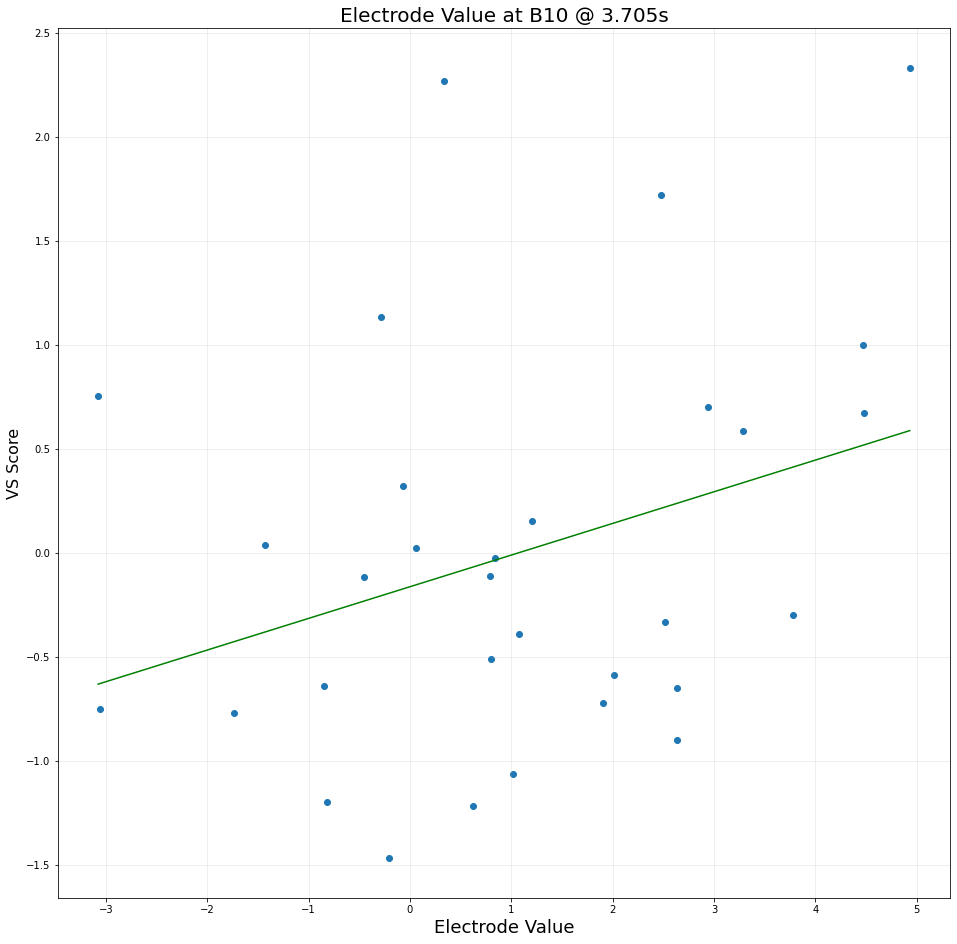

In [20]:
plt.clf()
plt.figure(figsize=(16, 16),facecolor='white')
plt.title("Electrode Value at B10 @ 3.705s",fontsize=20)
plt.grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
plt.scatter(design[:,0],design[:,1])
plt.xlabel('Electrode Value', fontsize=18)
plt.ylabel('VS Score', fontsize=16)
plt.plot(np.unique(design[:,0]), np.poly1d(np.polyfit(design[:,0], design[:,1], 1))(np.unique(design[:,0])), 'g')
plt.savefig("images/elect_val_463.png")
plt.show()

Getting R values for this

In [21]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(design[:,0],design[:,1])
print("R value: "+str(r_value))
print("R^2 value: "+str(r_value*r_value))

R value: 0.32503424557925886
R^2 value: 0.10564726079927796


Partition ERP

In [22]:
partition_data_name = "time_domain_partitions_partitioned_onsets_2_3_4_5_6_7_8_grand-average_partitions.mat"
p1,p2,p3 = ft_load.get_participant(participant_data_name, num_participants=40, baseline=(2.8,3.0))

# setting up plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 16))
fig.patch.set_facecolor('white')


# plotting all channels and GFP with locations
p1.plot(spatial_colors= True, picks=["B10"], gfp=False, xlim=[2.8, 3.9],axes=axes[0], show=False);
# plotting 2 significant ERPs no CI
p2.plot(spatial_colors= True, picks=["B10"], gfp=False, xlim=[2.8, 3.9],axes=axes[1], show=False);
# Plotting GFP on seperate graph
p3.plot(spatial_colors= True, picks=["B10"], gfp=False, xlim=[2.8, 3.9],axes=axes[2], show=False);

for plots in range(0,len(axes)):
    for text in list(axes[plots].texts):
        text.remove()    

axes[0].get_lines()[0].set_linewidth(2)
axes[1].get_lines()[0].set_linewidth(2)
axes[2].get_lines()[0].set_linewidth(2)
axes[1].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[0].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[2].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
axes[0].title.set_text('ERP Parrtition 1 B10')
axes[1].title.set_text('ERP Parrtition 2 B10')
axes[2].title.set_text('ERP Parrtition 3 B10')
fig.tight_layout()
plt.gca().legend(('B10'))
plt.rc('grid', linestyle="-", color='black')
plt.savefig("images/ERP_partitions.png")
plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

ValueError: too many values to unpack (expected 3)